In [2]:
%matplotlib inline

In [3]:
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
import tensorflow as tf
import numpy as np
from tensorflow.contrib import signal

In [5]:
import os
import sys
import re

In [6]:
BITRATE = 16                      # Bit rate
SAMRATE = 16000                   # Sample rate (Hz)
SAMTIME = 1000.0 / SAMRATE        # Sample time (ms)
MAXAMPS = float(2**BITRATE / 2)   # Max samples amplitute

In [7]:
# Load noise matrix
NOISE_CLIP_DIR = './data/noise_clips'
NOISE_MATRIX = np.loadtxt(os.path.join(NOISE_CLIP_DIR, 'noise_clips.csv'), delimiter=',')

In [8]:
# Tensorflow setup
sess = None
tf.logging.set_verbosity(tf.logging.INFO)

def reset_vars():
    """Initializes all tf variables"""
    sess.run(tf.global_variables_initializer())

def reset_tf():
    """Closes the current tf session and opens new session"""
    global sess
    if sess:
        sess.close()
    tf.reset_default_graph()
    sess = tf.Session()

## Create tensorflow preprocessing functions

Need functions for...

- Mel spectrogram (use `tf.contrib.signal library`)
- MFCCs (use `tf.contrib.signal library`)
- Zero crossing rate
- RMSE
- Window function

In [9]:
reset_tf()

In [10]:
# Test arrays
a = tf.placeholder(tf.float32, [16000,], name='a')
a2 = tf.placeholder(tf.float32, [5, 16000], name='a2')

b = 1.0 * np.arange(16000)
b2 = np.array([1.0 * np.arange(16000), 0.2 * np.arange(16000), 0.01 * np.arange(16000)])

c = np.array([1,2,4,-5,-6,-1,1,2,1,1,-1,1,4])
d = np.array([[1,2,3], [-4,5,6]])
d2 = np.array([[[1,2,3], [-4,5,6]],
               [[-1,2,3], [-4,5,6]],
               [[1,-2,3], [-4,5,6]],
               [[1,2,-3], [-4,5,6]]])
f = 0.8 * (np.random.rand(16000) - 0.5) + 0.5 * np.sin(0.2 * np.arange(16000)) + 0.5 * np.sin(0.05 * np.arange(16000))

In [11]:
def windower(arr, window=128, hop_length=32, rank=1):
    """Windower function that divides an array into fixed size windows"""
    overlap = window - hop_length
    length = arr.shape[rank - 1]
    indexer = tf.range(window)[None, :] + hop_length * tf.range((length - overlap) / hop_length)[:, None]
    return tf.gather(arr, indexer, axis=rank - 1)

In [12]:
windower(a)

<tf.Tensor 'Gather:0' shape=(497, 128) dtype=float32>

In [13]:
windower(a2, rank=2)

<tf.Tensor 'GatherV2:0' shape=(5, 497, 128) dtype=float32>

In [14]:
windower(b2, rank=2)

<tf.Tensor 'GatherV2_1:0' shape=(3, 497, 128) dtype=float64>

In [15]:
windower(b, rank=1)

<tf.Tensor 'Gather_1:0' shape=(497, 128) dtype=float64>

In [16]:
sess.run(windower(b2, rank=2))

array([[[  0.00000000e+00,   1.00000000e+00,   2.00000000e+00, ...,
           1.25000000e+02,   1.26000000e+02,   1.27000000e+02],
        [  3.20000000e+01,   3.30000000e+01,   3.40000000e+01, ...,
           1.57000000e+02,   1.58000000e+02,   1.59000000e+02],
        [  6.40000000e+01,   6.50000000e+01,   6.60000000e+01, ...,
           1.89000000e+02,   1.90000000e+02,   1.91000000e+02],
        ..., 
        [  1.58080000e+04,   1.58090000e+04,   1.58100000e+04, ...,
           1.59330000e+04,   1.59340000e+04,   1.59350000e+04],
        [  1.58400000e+04,   1.58410000e+04,   1.58420000e+04, ...,
           1.59650000e+04,   1.59660000e+04,   1.59670000e+04],
        [  1.58720000e+04,   1.58730000e+04,   1.58740000e+04, ...,
           1.59970000e+04,   1.59980000e+04,   1.59990000e+04]],

       [[  0.00000000e+00,   2.00000000e-01,   4.00000000e-01, ...,
           2.50000000e+01,   2.52000000e+01,   2.54000000e+01],
        [  6.40000000e+00,   6.60000000e+00,   6.80000000e+0

In [17]:
def tf_diff_axis(arr):
    """Equivalent of np.diff on last axis"""
    return arr[..., 1:] - arr[..., :-1]


def zero_crossing(arr, rank=1):
    """Calculates the zero crossing rate"""
    if rank == 1:
        nzc = tf.cast(tf.count_nonzero(tf_diff_axis(tf.sign(arr))), tf.float32)
    else:
        nzc = tf.cast(tf.count_nonzero(tf_diff_axis(tf.sign(arr)), axis=rank - 1), tf.float32)

    arrlen = tf.cast(arr.shape[rank - 1], tf.float32)
    return tf.divide(nzc, arrlen, name='zcr')

In [18]:
tf_diff_axis(d2)

array([[[ 1,  1],
        [ 9,  1]],

       [[ 3,  1],
        [ 9,  1]],

       [[-3,  5],
        [ 9,  1]],

       [[ 1, -5],
        [ 9,  1]]])

In [19]:
d

array([[ 1,  2,  3],
       [-4,  5,  6]])

In [20]:
tf_diff_axis(c)

array([ 1,  2, -9, -1,  5,  2,  1, -1,  0, -2,  2,  3])

In [21]:
sess.run(zero_crossing(d, rank=2))

array([ 0.        ,  0.33333334], dtype=float32)

In [22]:
sess.run(zero_crossing(c, rank=1))

0.30769232

In [23]:
def rms_energy(arr, rank=1, maxamps=1.0):
    """Calculates the RMS energy of the wave"""
    if rank == 1:
        return tf.sqrt(tf.reduce_mean(tf.square(arr / maxamps)), name='rmse')
    else:
        return tf.sqrt(tf.reduce_mean(tf.square(arr / maxamps), axis=rank - 1), name='rmse')

In [24]:
# My windower function is faster
sess.run(signal.frame(b, 128, 32))

array([[  0.00000000e+00,   1.00000000e+00,   2.00000000e+00, ...,
          1.25000000e+02,   1.26000000e+02,   1.27000000e+02],
       [  3.20000000e+01,   3.30000000e+01,   3.40000000e+01, ...,
          1.57000000e+02,   1.58000000e+02,   1.59000000e+02],
       [  6.40000000e+01,   6.50000000e+01,   6.60000000e+01, ...,
          1.89000000e+02,   1.90000000e+02,   1.91000000e+02],
       ..., 
       [  1.58080000e+04,   1.58090000e+04,   1.58100000e+04, ...,
          1.59330000e+04,   1.59340000e+04,   1.59350000e+04],
       [  1.58400000e+04,   1.58410000e+04,   1.58420000e+04, ...,
          1.59650000e+04,   1.59660000e+04,   1.59670000e+04],
       [  1.58720000e+04,   1.58730000e+04,   1.58740000e+04, ...,
          1.59970000e+04,   1.59980000e+04,   1.59990000e+04]])

In [25]:
stfts = signal.stft(tf.cast(f, tf.float32), frame_length=256, frame_step=16, fft_length=128)

In [26]:
magnitude_spectrograms = tf.abs(stfts)

In [27]:
# Warp the linear-scale, magnitude spectrograms into the mel-scale
num_spectrogram_bins = magnitude_spectrograms.shape[-1].value
lower_edge_hertz = 80.0
upper_edge_hertz = 7600.0
num_mel_bins = 64

mel_weight_mat = signal.linear_to_mel_weight_matrix(num_mel_bins,
                                                    num_spectrogram_bins,
                                                    SAMRATE,
                                                    lower_edge_hertz,
                                                    upper_edge_hertz)

mel_spectrograms = tf.tensordot(magnitude_spectrograms, mel_weight_mat, 1)

# Note: Shape inference for tf.tensordot does not currently handle this case
mel_spectrograms.set_shape(magnitude_spectrograms.shape[:-1].concatenate(mel_weight_mat.shape[-1:]))

In [28]:
x1 = sess.run(mel_spectrograms)

In [29]:
# Matmul only works for single file, hence use of tensordot
x2 = sess.run(tf.matmul(magnitude_spectrograms, mel_weight_mat))

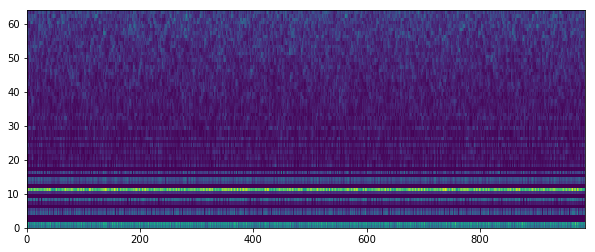

In [30]:
plt.figure(figsize=(10, 4))
plt.pcolormesh(x1.T);

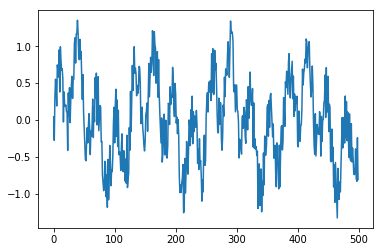

In [31]:
plt.plot(f[:500]);

## Function for full batch process

In [32]:
NOISE_MATRIX

array([[-0.71797845, -0.86306345, -1.        , ...,  0.00793481,
         0.01596118,  0.13812677],
       [ 0.27036348,  0.14755699,  0.15768914, ..., -0.09686575,
        -0.24463637, -0.36512345],
       [-0.06485183, -0.15851314,  0.07629627, ...,  0.16415906,
         0.09308145, -0.06280709],
       ..., 
       [ 0.10189928, -0.0955158 ,  0.17062022, ..., -0.14555915,
         0.42666877,  0.44093309],
       [-0.15319491, -0.18576196,  0.02255593, ..., -0.15782969,
         0.00407861, -0.10950439],
       [-0.07755269,  0.07310942,  0.18612061, ...,  0.10655091,
         0.27504458,  0.18682218]])

In [33]:
def signalProcessBatch(signals, add_noise=True, noise_factor=0.1, noise_frac=0.75, window=512,
                       maxamps=1.0, sr=16000, num_mel_bins=64, num_mfccs=19):
    """Function to perform all the DSP preprocessing and feature extraction.
       Returns the Mel spectrum, MFCCs, ZCR and RMSE.
       Works on a batch of num_files files.
       Input signals : [num_files, samples]
       Output        : [num_files, num_windows, num_mfccs]"""

    if add_noise:
        # Checks for both array input and tensor input
        num_files = tf.shape(signals)[0]
        #try:
        #    num_files = signals.shape[0].value
        #    if not num_files:
        #        num_files = -1
        #except AttributeError:
        #    num_files = signals.shape[0]

        idx = tf.random_uniform((num_files,), 0, NOISE_MATRIX.shape[0], dtype=tf.int32)
        noise = tf.cast(tf.gather(NOISE_MATRIX, idx), tf.float32)
        nf = tf.cast(tf.greater(tf.random_uniform([num_files, 1]), noise_frac), tf.float32)
        
        signals = signals + noise_factor * maxamps * noise * nf

    hop_length = window / 4
    signals32 = tf.cast(signals, tf.float32)
    signals_w = windower(signals32, window=window, hop_length=hop_length, rank=2)

    zcr = zero_crossing(signals_w, rank=3)
    rmse = rms_energy(signals_w, rank=3, maxamps=maxamps)

    stfts = signal.stft(signals32, frame_length=window, frame_step=hop_length, fft_length=window)
    magnitude_spectrograms = tf.abs(stfts)

    num_spectrogram_bins = magnitude_spectrograms.shape[-1].value
    lower_edge_hertz = 80.0
    upper_edge_hertz = 7600.0

    mel_weight_mat = signal.linear_to_mel_weight_matrix(num_mel_bins,
                                                        num_spectrogram_bins,
                                                        sr,
                                                        lower_edge_hertz,
                                                        upper_edge_hertz)

    mel_spectrograms = tf.tensordot(magnitude_spectrograms, mel_weight_mat, 1)
    mel_spectrograms.set_shape(magnitude_spectrograms.shape[:-1].concatenate(mel_weight_mat.shape[-1:]))

    log_offset = 1e-8
    log_mel_spectrograms = tf.log(mel_spectrograms + log_offset, name='log_mel_spectrograms')

    mfccs = signal.mfccs_from_log_mel_spectrograms(log_mel_spectrograms)[..., :num_mfccs]
    mfccs = tf.identity(mfccs, name='mfccs')

    return mfccs, log_mel_spectrograms, zcr, rmse

In [34]:
a2.shape[0].value

5

In [35]:
signalProcessBatch(a2)

(<tf.Tensor 'mfccs:0' shape=(5, 122, 19) dtype=float32>,
 <tf.Tensor 'log_mel_spectrograms:0' shape=(5, 122, 64) dtype=float32>,
 <tf.Tensor 'zcr_2:0' shape=(5, 122) dtype=float32>,
 <tf.Tensor 'rmse:0' shape=(5, 122) dtype=float32>)

In [36]:
sess.run(signalProcessBatch(b2))

(array([[[ -7.97385645,  20.61150742,   3.75420046, ...,   0.1953465 ,
            0.25328481,   0.16136916],
         [ -7.88838053,  20.52875328,   3.82384348, ...,   0.18631293,
            0.26750574,   0.14367102],
         [ -7.77668667,  20.42429161,   3.90994239, ...,   0.24778511,
            0.17406394,   0.2419122 ],
         ..., 
         [ -2.18255639,  15.65145779,   6.85610914, ...,   0.61380404,
           -0.37004662,   0.52652884],
         [ -2.21438909,  15.66157436,   6.85999775, ...,   0.60594964,
           -0.20235783,   0.36585033],
         [ -2.4410944 ,  15.91108227,   6.62845421, ...,   0.65292984,
           -0.37756562,   0.56430495]],
 
        [[  8.06023026,   0.52984411,   5.86458206, ...,   0.04010781,
            0.63197255,   0.41365302],
         [  7.42860937,   0.54155457,   6.60659933, ...,  -0.09915925,
            0.17845654,   0.12949841],
         [  7.64222002,   1.01642466,   6.23269939, ...,   0.08059637,
            0.0927991 ,   0.348

## Testing

In [37]:
X_data = tf.placeholder(tf.float32, [None, SAMRATE], name='X_data')

In [38]:
X_data

<tf.Tensor 'X_data:0' shape=(?, 16000) dtype=float32>

In [39]:
signalProcessBatch(a2)

(<tf.Tensor 'mfccs_2:0' shape=(5, 122, 19) dtype=float32>,
 <tf.Tensor 'log_mel_spectrograms_2:0' shape=(5, 122, 64) dtype=float32>,
 <tf.Tensor 'zcr_4:0' shape=(5, 122) dtype=float32>,
 <tf.Tensor 'rmse_2:0' shape=(5, 122) dtype=float32>)

In [40]:
test = signalProcessBatch(X_data)

In [41]:
X_data.shape[0]

Dimension(None)

In [42]:
sess.run(tf.greater(tf.random_uniform((5,1)), 0.75))

array([[False],
       [ True],
       [False],
       [False],
       [False]], dtype=bool)

In [43]:
sess.run(test, feed_dict={X_data:np.zeros((5,16000))})

(array([[[ -7.84825420e+00,  -7.00975704e+00,   1.96642864e+00, ...,
            5.57062149e-01,  -1.52804896e-01,   7.09766001e-02],
         [ -8.31115913e+00,  -6.83206654e+00,   1.68601203e+00, ...,
            3.72848392e-01,  -2.72097170e-01,   4.04551834e-01],
         [ -9.06225872e+00,  -6.02333593e+00,   1.98536956e+00, ...,
            5.72135866e-01,  -2.51268625e-01,  -2.26284847e-01],
         ..., 
         [ -1.40735731e+01,  -9.13378477e-01,   3.59477580e-01, ...,
           -5.35454392e-01,  -5.06326616e-01,  -7.87843466e-02],
         [ -1.28437471e+01,  -8.00126791e-01,   8.19304109e-01, ...,
           -4.60385025e-01,   1.32397205e-01,   6.55912697e-01],
         [ -1.15429144e+01,  -1.59686923e+00,   1.42240787e+00, ...,
           -1.00579470e-01,   3.54304701e-01,   9.36542675e-02]],
 
        [[ -8.65147495e+00,  -1.52450454e+00,  -2.78553581e+00, ...,
           -2.86161155e-01,   2.21733093e-01,   3.54274176e-02],
         [ -8.74475956e+00,  -1.75051153e+00

In [45]:
b2

array([[  0.00000000e+00,   1.00000000e+00,   2.00000000e+00, ...,
          1.59970000e+04,   1.59980000e+04,   1.59990000e+04],
       [  0.00000000e+00,   2.00000000e-01,   4.00000000e-01, ...,
          3.19940000e+03,   3.19960000e+03,   3.19980000e+03],
       [  0.00000000e+00,   1.00000000e-02,   2.00000000e-02, ...,
          1.59970000e+02,   1.59980000e+02,   1.59990000e+02]])

In [46]:
X_mfccs, X_log_mel_spectrograms, X_zcr, X_rmse = sess.run(signalProcessBatch(b2))

In [48]:
X_mfccs.shape

(3, 122, 19)

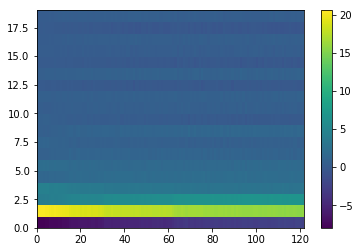

In [58]:
plt.pcolormesh(X_mfccs[0].T)
plt.colorbar();

In [66]:
X_mfccs_norm = sess.run(tf.nn.l2_normalize(X_mfccs, 1, epsilon=1e-8))

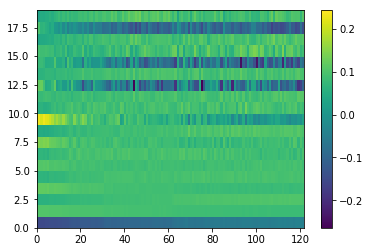

In [67]:
plt.pcolormesh(X_mfccs_norm[0].T)
plt.colorbar();

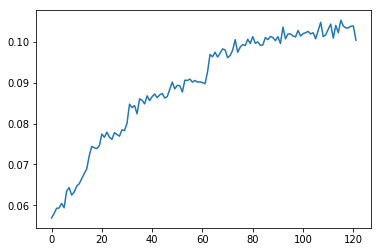

In [79]:
plt.plot(X_mfccs_norm[0].T[2]);